# Clustering UFC Fighter Attributes: What Makes a Winning Fighter?
Adam Pfister - Oregon, USA - December 7, 2019  

This project is an extension of my first capstone project: Predicting UFC Fights With Supervised Learning. In this project I will attempt to use unsupervised learning and dimensionality reduction methods to discover the patterns and key features that make up a winning fighter. These methods include feature engineering, exploratory data analysis, Kmeans, principal component analysis, T-sne, and mean shift. 

The data comes from Kaggle (https://www.kaggle.com/rajeevw/ufcdata). A big thank you to the originator of this data, Rajeev Warrier. It is detailed and well put-together with zero missing data.  

Below in quotes is info about the two original datasets directly from its Kaggle page:  
 
" This is a list of every UFC fight in the history of the organisation. Every row contains information about both fighters, fight details and the winner. The data was scraped from ufcstats website. After fightmetric ceased to exist, this came into picture. I saw that there was a lot of information on the website about every fight and every event and there were no existing ways of capturing all this. I used beautifulsoup to scrape the data and pandas to process it. It was a long and arduous process, please forgive any mistakes. I have provided the raw files incase anybody wants to process it differently. This is my first time creating a dataset, any suggestions and corrections are welcome! Incase anyone wants to check out the work, I have all uploaded all the code files, including the scraping module here.  

Each row is a compilation of both fighter stats. Fighters are represented by 'red' and 'blue' (for red and blue corner). So for instance, red fighter has the complied average stats of all the fights except the current one. The stats include damage done by the red fighter on the opponent and the damage done by the opponent on the fighter (represented by 'opp' in the columns) in all the fights this particular red fighter has had, except this one as it has not occured yet (in the data). Same information exists for blue fighter. The target variable is 'Winner' which is the only column that tells you what happened. Here are some column definitions. "

---------------------------------------------------

### CONTENTS
1. __Data Cleaning and Feature Engineering__  
    > 1. Clean column names
    > 2. Parse date/time
    > 3. Create new variables
    > 4. Reorder main dataframe
    > 5. Create key feature dataframe
2. __Exploratory Data Analysis__  
    > 1. Missing data
    > 2. .info()
    > 3. .head()
    > 4. .describe() 
    > 5. Correlation matrix
    > 6. Distributions
    > 7. Pairplots
3. __K Means__  
    > 1. Elbow method plot
    > 2. Silhouette scores and scatterplots
    > 3. SelectKbest
    > 4. SelectPercentile
4. __Principal Component Analysis__
    > 1. Transform and create table
    > 2. Scree plot of explained variance
    > 3. 2D scatterplots
    > 4. 3D scatterplots
5. __T-SNE__
    > 1. Transform and create table
    > 2. 2D scatterplots
    > 3. 3D scatterplots
6. __Mean Shift__
    > 1. Estimated number of clusters
8. __Summary and Conclusion__
10. __Acknowledgments__

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy
import sklearn

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# import original kaggle datasets
df_clean = pd.read_csv(r'C:\Users\AP\Desktop\ufc-fight-stats-clean.csv')
df_raw = pd.read_csv(r'C:\Users\AP\Desktop\ufc-fight-stats.csv')

# change all columns to lower case for ease and consistency of typing
df_clean.columns = map(str.lower, df_clean.columns)
df_raw.columns = map(str.lower, df_raw.columns)

------------------

### Data Cleaning and Feature Engineering  
1. Clean column names
2. Parse date/time
3. Create new variables
4. Reorder main dataframe
5. Create key feature dataframe

In [3]:
# rename columns for easier typing/copy-paste
df_clean['r_win_ko_tko'] = df_clean['r_win_by_ko/tko']
df_clean['b_win_ko_tko'] = df_clean['b_win_by_ko/tko']

df_clean['r_total_time_fought_secs'] = df_clean['r_total_time_fought(seconds)']
df_clean['b_total_time_fought_secs'] = df_clean['b_total_time_fought(seconds)']

df_clean['r_stance_open'] = df_clean['r_stance_open stance']
df_clean['b_stance_open'] = df_clean['b_stance_open stance']

df_clean['weight_class_light_heavyweight'] = df_clean['weight_class_light heavyweight']
df_clean['weight_class_catch_weight'] = df_clean['weight_class_catch weight']
df_clean['weight_class_open_weight'] = df_clean['weight_class_open weight']
df_clean['weight_class_women_bantamweight'] = df_clean["weight_class_women's bantamweight"]
df_clean['weight_class_women_featherweight'] = df_clean["weight_class_women's featherweight"]
df_clean['weight_class_women_flyweight'] = df_clean["weight_class_women's flyweight"]
df_clean['weight_class_women_strawweight'] = df_clean["weight_class_women's strawweight"]

In [4]:
# parse date/time into separate columns
df_clean['date'] = pd.to_datetime(df_raw.date)

df_clean['day'] = df_clean.date.dt.day
df_clean['month'] = df_clean.date.dt.month
df_clean['year'] = df_clean.date.dt.year

In [5]:
# convert title bout from true/false to binary
df_clean.title_bout = df_clean.title_bout.astype(int)

--------------------

### Creat Key Variables    
- __Total fights:__ wins + losses + draws, also used in calculating aggression score
- __Aggression score:__ interaction between wins by ko/tko, submission, and doctor stoppage
- __Striking score:__ interaction between striking attempts and strikes landed
- __Submission score:__ interaction between submission attempts and fights ended in submission
- __Wrestling score:__ interaction between passes, reverses, and takedowns
- __Grappling score:__ interaction between submission and wrestling scores
- __Opponent total strike pct:__ interaction between strikes attempted against and strikes absorbed
- __Defense score:__ interaction between % strikes attempted against, takedowns absorbed, and submission attempts absorbed
- __Experience score:__ interaction between total fights and total rounds fought

In [6]:
# create new variables
# r = red corner
# b = blue corner

# total fights
df_clean['r_total_fights'] = df_clean.r_wins + df_clean.r_losses + df_clean.r_draw
df_clean['b_total_fights'] = df_clean.b_wins + df_clean.b_losses + df_clean.b_draw

# aggression score
df_clean['r_aggression'] = ((df_clean.r_win_ko_tko + df_clean.r_win_by_submission +
                            df_clean.r_win_by_tko_doctor_stoppage) / df_clean.r_total_fights)
df_clean['b_aggression'] = ((df_clean.b_win_ko_tko + df_clean.b_win_by_submission +
                            df_clean.b_win_by_tko_doctor_stoppage) / df_clean.b_total_fights)

# striking score
df_clean['r_striking'] = (df_clean.r_avg_total_str_landed / 
                          df_clean.r_avg_total_str_att) * df_clean.r_avg_total_str_landed
df_clean['b_striking'] = (df_clean.b_avg_total_str_landed / 
                          df_clean.b_avg_total_str_att) * df_clean.b_avg_total_str_landed

# submission score
df_clean['r_submission'] = df_clean.r_win_by_submission / df_clean.r_avg_sub_att**2
df_clean['b_submission'] = df_clean.b_win_by_submission / df_clean.b_avg_sub_att**2

# wrestling score
df_clean['r_wrestle'] = df_clean.r_avg_pass + df_clean.r_avg_rev + df_clean.r_avg_td_landed
df_clean['b_wrestle'] = df_clean.b_avg_pass + df_clean.b_avg_rev + df_clean.b_avg_td_landed

# grappling score
df_clean['r_grapple'] = df_clean.r_submission + df_clean.r_wrestle
df_clean['b_grapple'] = df_clean.b_submission + df_clean.b_wrestle

# opponent total strike pct
df_clean['r_opp_total_str_pct'] = (df_clean.r_avg_opp_total_str_landed / 
                                   df_clean.r_avg_opp_total_str_att) * df_clean.r_avg_opp_total_str_landed
df_clean['b_opp_total_str_pct'] = (df_clean.b_avg_opp_total_str_landed / 
                                   df_clean.b_avg_opp_total_str_att) * df_clean.b_avg_opp_total_str_landed

# defense score
df_clean['r_defense'] = (df_clean.r_opp_total_str_pct * 
                         df_clean.r_avg_opp_td_pct * (df_clean.r_avg_opp_sub_att / 100))
df_clean['b_defense'] = (df_clean.b_opp_total_str_pct * 
                         df_clean.b_avg_opp_td_pct * (df_clean.b_avg_opp_sub_att / 100))

# experience score
df_clean['r_experience'] = (df_clean.r_total_fights * df_clean.r_total_rounds_fought) / 100
df_clean['b_experience'] = (df_clean.b_total_fights * df_clean.b_total_rounds_fought) / 100

In [7]:
# create binary winner columns 
df_dum_win = pd.concat([df_clean, pd.get_dummies(df_clean.winner, prefix='win', dummy_na=True)], axis=1)

# combine dummy columns to raw dataset
df_clean = pd.concat([df_dum_win, df_raw], axis=1)

# convert columns to lowercase
df_clean.columns = map(str.lower, df_clean.columns)

In [8]:
# drop duplicate columns
df_clean = df_clean.loc[:,~df_clean.columns.duplicated()]

# replace infinite values with nan
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# drop null rows
df_clean.dropna(axis=0, inplace=True)

In [9]:
# rename/copy dataframe
df = df_clean

In [10]:
# create numerical df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)

In [11]:
# reorder columns by similarity
df = df[['date',
         'day',
         'month',
         'year',
         'location',
         'referee',
         'title_bout',
         'no_of_rounds',
         'weight_class',
         'r_fighter',
         'b_fighter',
         'winner',
         'win_red',
         'win_blue',
         'r_age',
         'r_height_cms',
         'r_reach_cms',
         'r_weight_lbs',
         'r_wins',
         'r_losses',
         'r_draw',
         'r_aggression',
         'r_current_win_streak',
         'r_longest_win_streak',
         'r_current_lose_streak',
         'r_win_by_decision_majority',
         'r_win_by_decision_split',
         'r_win_by_decision_unanimous',
         'r_win_by_submission',
         'r_win_ko_tko',
         'r_win_by_tko_doctor_stoppage',
         'r_stance',
         'r_stance_open',
         'r_stance_orthodox',
         'r_stance_southpaw',
         'r_stance_switch',
         'r_defense',
         'r_experience',
         'r_striking',
         'r_opp_total_str_pct',
         'r_avg_body_att',
         'r_avg_body_landed',
         'r_avg_clinch_att',
         'r_avg_clinch_landed',
         'r_avg_distance_att',
         'r_avg_distance_landed',
         'r_avg_ground_att',
         'r_avg_ground_landed',
         'r_avg_head_att',
         'r_avg_head_landed',
         'r_avg_kd',
         'r_avg_leg_att',
         'r_avg_leg_landed',
         'r_avg_pass',
         'r_avg_rev',
         'r_avg_sig_str_att',
         'r_avg_sig_str_landed',
         'r_avg_sig_str_pct',
         'r_avg_sub_att',
         'r_avg_td_att',
         'r_avg_td_landed',
         'r_avg_td_pct',
         'r_avg_total_str_att',
         'r_avg_total_str_landed',
         'r_avg_opp_body_att',
         'r_avg_opp_body_landed',
         'r_avg_opp_clinch_att',
         'r_avg_opp_clinch_landed',
         'r_avg_opp_distance_att',
         'r_avg_opp_distance_landed',
         'r_avg_opp_ground_att',
         'r_avg_opp_ground_landed',
         'r_avg_opp_head_att',
         'r_avg_opp_head_landed',
         'r_avg_opp_kd',
         'r_avg_opp_leg_att',
         'r_avg_opp_leg_landed',
         'r_avg_opp_pass',
         'r_avg_opp_rev',
         'r_avg_opp_sig_str_att',
         'r_avg_opp_sig_str_landed',
         'r_avg_opp_sig_str_pct',
         'r_avg_opp_sub_att',
         'r_avg_opp_td_att',
         'r_avg_opp_td_landed',
         'r_avg_opp_td_pct',
         'r_avg_opp_total_str_att',
         'r_avg_opp_total_str_landed',
         'r_total_fights',
         'r_total_rounds_fought',
         'r_total_time_fought_secs',
         'r_total_title_bouts',
         'b_age',
         'b_height_cms',
         'b_reach_cms',
         'b_weight_lbs',
         'b_wins',
         'b_losses',
         'b_draw',
         'b_total_fights',
         'b_aggression',
         'b_current_win_streak',
         'b_longest_win_streak',
         'b_current_lose_streak',
         'b_win_by_decision_majority',
         'b_win_by_decision_split',
         'b_win_by_decision_unanimous',
         'b_win_by_submission',
         'b_win_ko_tko',
         'b_win_by_tko_doctor_stoppage',
         'b_stance',
         'b_stance_open',
         'b_stance_orthodox',
         'b_stance_sideways',
         'b_stance_southpaw',
         'b_stance_switch',
         'b_defense',
         'b_experience',
         'b_striking',
         'b_opp_total_str_pct',
         'b_avg_body_att',
         'b_avg_body_landed',
         'b_avg_clinch_att',
         'b_avg_clinch_landed',
         'b_avg_distance_att',
         'b_avg_distance_landed',
         'b_avg_ground_att',
         'b_avg_ground_landed',
         'b_avg_head_att',
         'b_avg_head_landed',
         'b_avg_kd',
         'b_avg_leg_att',
         'b_avg_leg_landed',
         'b_avg_pass',
         'b_avg_rev',
         'b_avg_sig_str_att',
         'b_avg_sig_str_landed',
         'b_avg_sig_str_pct',
         'b_avg_sub_att',
         'b_avg_td_att',
         'b_avg_td_landed',
         'b_avg_td_pct',
         'b_avg_total_str_att',
         'b_avg_total_str_landed',
         'b_avg_opp_body_att',
         'b_avg_opp_body_landed',
         'b_avg_opp_clinch_att',
         'b_avg_opp_clinch_landed',
         'b_avg_opp_distance_att',
         'b_avg_opp_distance_landed',
         'b_avg_opp_ground_att',
         'b_avg_opp_ground_landed',
         'b_avg_opp_head_att',
         'b_avg_opp_head_landed',
         'b_avg_opp_kd',
         'b_avg_opp_leg_att',
         'b_avg_opp_leg_landed',
         'b_avg_opp_pass',
         'b_avg_opp_rev',
         'b_avg_opp_sig_str_att',
         'b_avg_opp_sig_str_landed',
         'b_avg_opp_sig_str_pct',
         'b_avg_opp_sub_att',
         'b_avg_opp_td_att',
         'b_avg_opp_td_landed',
         'b_avg_opp_td_pct',
         'b_avg_opp_total_str_att',
         'b_avg_opp_total_str_landed',
         'b_total_rounds_fought',
         'b_total_time_fought_secs',
         'b_total_title_bouts',
         'weight_class_heavyweight',
         'weight_class_light_heavyweight',
         'weight_class_middleweight',
         'weight_class_welterweight',
         'weight_class_lightweight',
         'weight_class_featherweight',
         'weight_class_bantamweight',
         'weight_class_flyweight',
         'weight_class_catch_weight',
         'weight_class_open_weight',
         'weight_class_women_bantamweight',
         'weight_class_women_featherweight',
         'weight_class_women_flyweight',
         'weight_class_women_strawweight',
         ]]

In [12]:
# create key feature dataframe
df_keys = df_clean[['win_red',
                    'r_experience',
                    'r_aggression',
                    'r_striking',
                    'r_submission',
                    'r_wrestle',
                    'r_defense',
                    'b_experience',
                    'b_aggression',
                    'b_striking',
                    'b_submission',
                    'b_wrestle',
                    'b_defense',
                    ]]

------------------

### Exploratory Data Analysis  
1. Missing data
2. .info()
3. .head()
4. .describe() 
5. Correlation matrix
6. Distributions
7. Pairplots

In [13]:
# calculate missing data value and percent - main dataset
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
weight_class_women_strawweight,0,0.0
r_avg_sig_str_pct,0,0.0
r_avg_opp_clinch_att,0,0.0
r_avg_opp_body_landed,0,0.0
r_avg_opp_body_att,0,0.0


#### Observations
- Zero missing data

In [14]:
# basic info - key feature dataset
df_keys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1595 entries, 0 to 3588
Data columns (total 13 columns):
win_red         1595 non-null float64
r_experience    1595 non-null float64
r_aggression    1595 non-null float64
r_striking      1595 non-null float64
r_submission    1595 non-null float64
r_wrestle       1595 non-null float64
r_defense       1595 non-null float64
b_experience    1595 non-null float64
b_aggression    1595 non-null float64
b_striking      1595 non-null float64
b_submission    1595 non-null float64
b_wrestle       1595 non-null float64
b_defense       1595 non-null float64
dtypes: float64(13)
memory usage: 174.5 KB


#### Observations
- The key feature dataframe contains 13 variables and 1595 instances

In [15]:
# display sample - key feature dataset
df_keys.head()

,win_red,r_experience,r_aggression,r_striking,r_submission,r_wrestle,r_defense,b_experience,b_aggression,b_striking,b_submission,b_wrestle,b_defense
0,1.0,2.70,0.200000,36.757583,0.000000,3.100000,0.000000,0.45,0.600000,8.387952,6.250000,0.600000,0.000000
1,1.0,1.75,0.285714,65.479348,10.888889,4.285714,0.018000,2.90,0.100000,30.524008,0.000000,1.300000,0.060679
2,1.0,4.95,0.666667,30.222256,6.000000,0.866667,0.001277,21.08,0.516129,26.625606,47.652892,1.709677,0.001518
6,1.0,3.84,0.333333,53.154669,5.333333,3.333333,0.003725,2.76,0.500000,21.976461,6.750000,1.250000,0.000000
11,1.0,1.08,0.000000,25.567882,0.000000,0.000000,0.000000,1.44,0.250000,56.358340,4.000000,2.625000,0.065104


In [16]:
# basic statistics - key feature dataset
df_keys.describe()

,win_red,r_experience,r_aggression,r_striking,r_submission,r_wrestle,r_defense,b_experience,b_aggression,b_striking,b_submission,b_wrestle,b_defense
count,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000
mean,0.667085,2.496044,0.406351,30.430426,6.150931,3.359612,0.042221,1.754451,0.391999,30.225987,5.197114,3.195894,0.044840
std,0.471404,3.354785,0.237787,16.549406,13.812459,2.294997,0.095294,2.839197,0.260270,18.734895,13.686014,2.453941,0.124083
min,0.000000,0.010000,0.000000,0.045455,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.360000,0.250000,19.770626,0.000000,1.714286,0.000000,0.210000,0.222222,18.262896,0.000000,1.500000,0.000000
50%,1.000000,1.260000,0.400000,27.321502,1.777778,2.800000,0.014301,0.650000,0.375000,27.129944,1.000000,2.600000,0.012017
75%,1.000000,3.230000,0.500000,38.035042,7.000868,4.750000,0.043416,2.000000,0.500000,37.052822,4.500000,4.436508,0.047364
max,1.000000,22.040000,1.000000,138.958506,224.999998,19.000000,1.808572,21.080000,1.000000,182.413793,256.000000,21.000000,2.950828


#### Observations
- Both striking and submission variables have high standard deviations, implying robust variability between fighters' skills in these two areas and possibly non-normality
- The means of each red/blue variables (i.e., r_striking and b_striking) seem in relation to each other

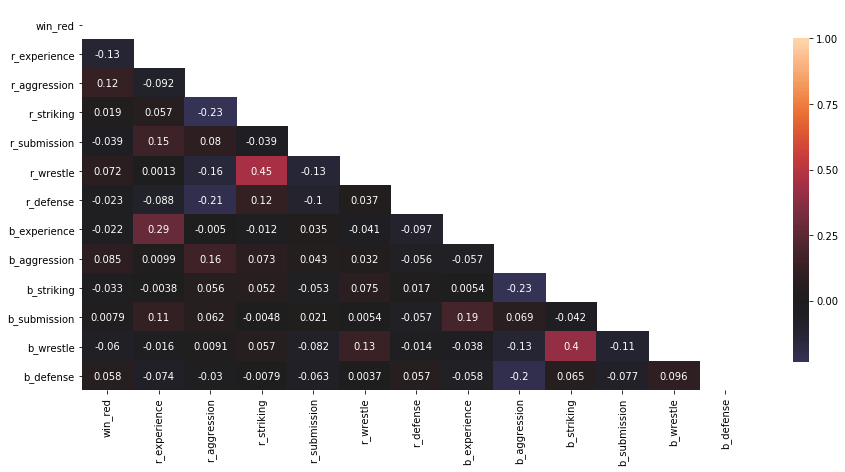

In [17]:
# correlation matrix - key feature dataset
corr = df_keys.corr()

# generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot heatmap correlation
plt.figure(figsize=(15,7))
sns.heatmap(corr, mask=mask, cbar_kws={"shrink": .85}, annot=True, center=0)

plt.show()

#### Observations
- There does not appear to be much linear correlation between the feature variables
- Small correlation between red striking and red wrestling, and blue striking and blue wrestling

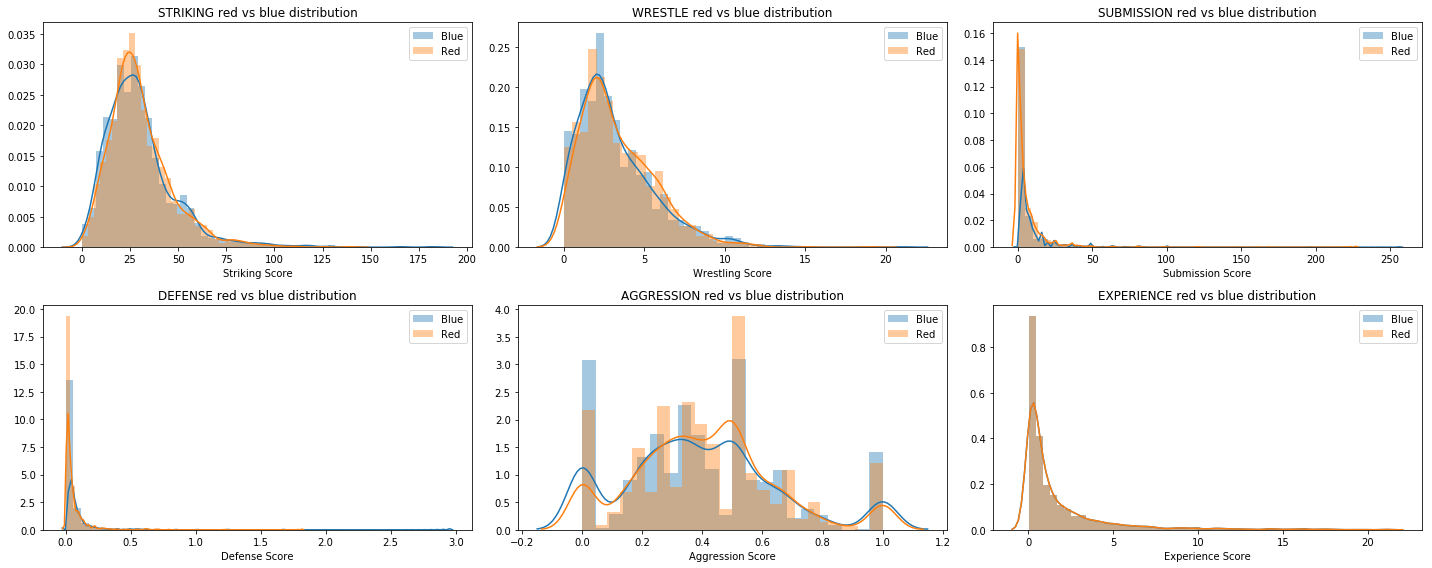

In [18]:
# distributions comparison
plt.figure(figsize=(20,8))

# experience distribution - red vs blue 
plt.subplot(2,3,1)
sns.distplot(df_keys.b_striking)
sns.distplot(df_keys.r_striking)
plt.title('STRIKING red vs blue distribution')
plt.xlabel('Striking Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

# experience distribution - red vs blue
plt.subplot(2,3,2)
sns.distplot(df_keys.b_wrestle)
sns.distplot(df_keys.r_wrestle)
plt.title('WRESTLE red vs blue distribution')
plt.xlabel('Wrestling Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

# aggression distribution - red vs blue
plt.subplot(2,3,3)
sns.distplot(df_keys.b_submission)
sns.distplot(df_keys.r_submission)
plt.title('SUBMISSION red vs blue distribution')
plt.xlabel('Submission Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

# submission distribution - red vs blue
plt.subplot(2,3,4)
sns.distplot(df_keys.b_defense)
sns.distplot(df_keys.r_defense)
plt.title('DEFENSE red vs blue distribution')
plt.xlabel('Defense Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

# wrestle distribution - red vs blue
plt.subplot(2,3,5)
sns.distplot(df_keys.b_aggression)
sns.distplot(df_keys.r_aggression)
plt.title('AGGRESSION red vs blue distribution')
plt.xlabel('Aggression Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

# defense distribution - red vs blue
plt.subplot(2,3,6)
sns.distplot(df_keys.b_experience)
sns.distplot(df_keys.b_experience)
plt.title('EXPERIENCE red vs blue distribution')
plt.xlabel('Experience Score')
plt.legend(labels=['Blue','Red'], loc="upper right")

plt.tight_layout()
plt.show()

#### Observations
- All distributions seem to be long-tailed except for aggression scores, which looks similar to normal
- The data will be preprocessed to normalize all on the same scale before clustering

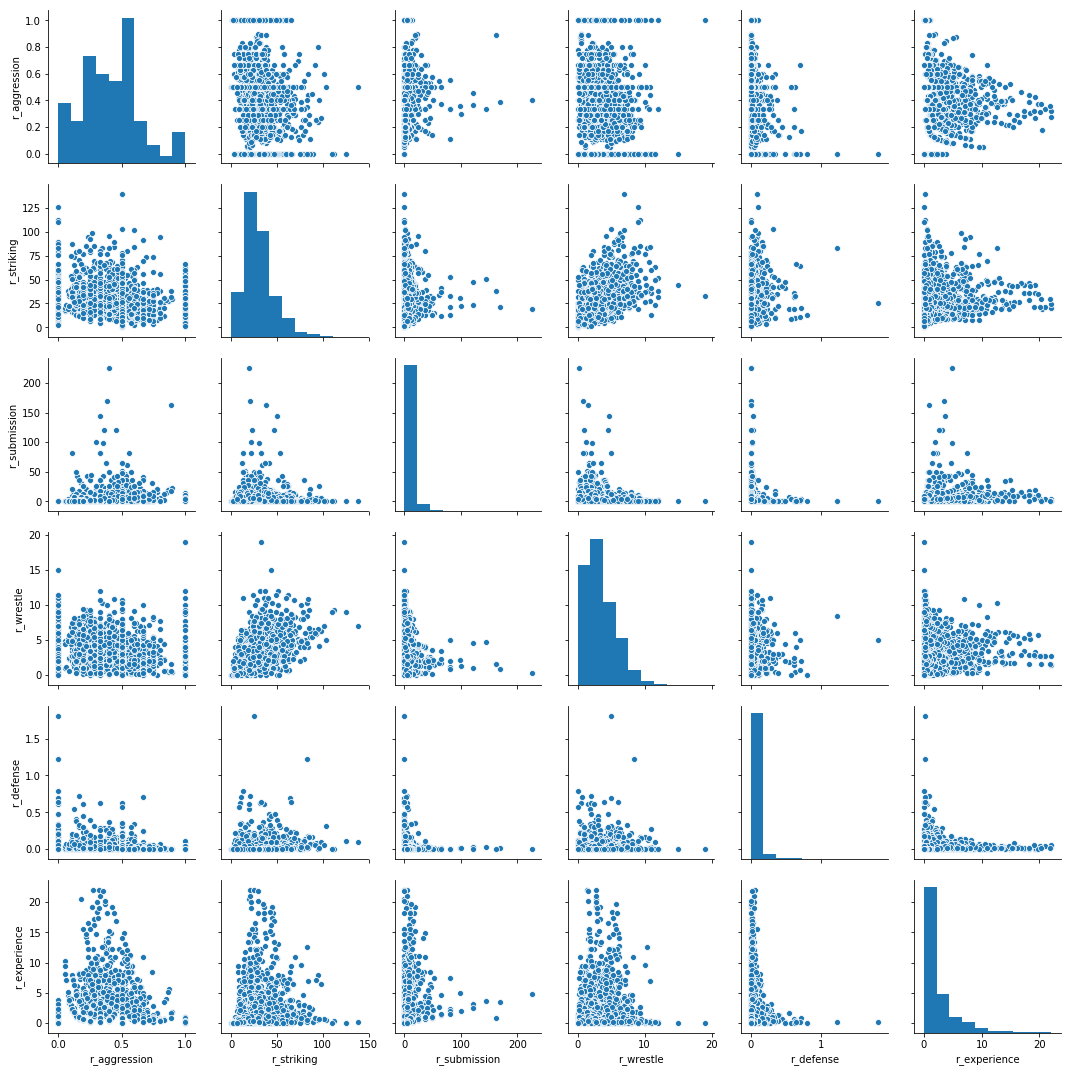

In [19]:
# red corner pairplot - key feature dataset
sns.pairplot(df_keys[['r_aggression',
                      'r_striking',
                      'r_submission',
                      'r_wrestle',
                      'r_defense',
                      'r_experience',
                      ]])

plt.show()

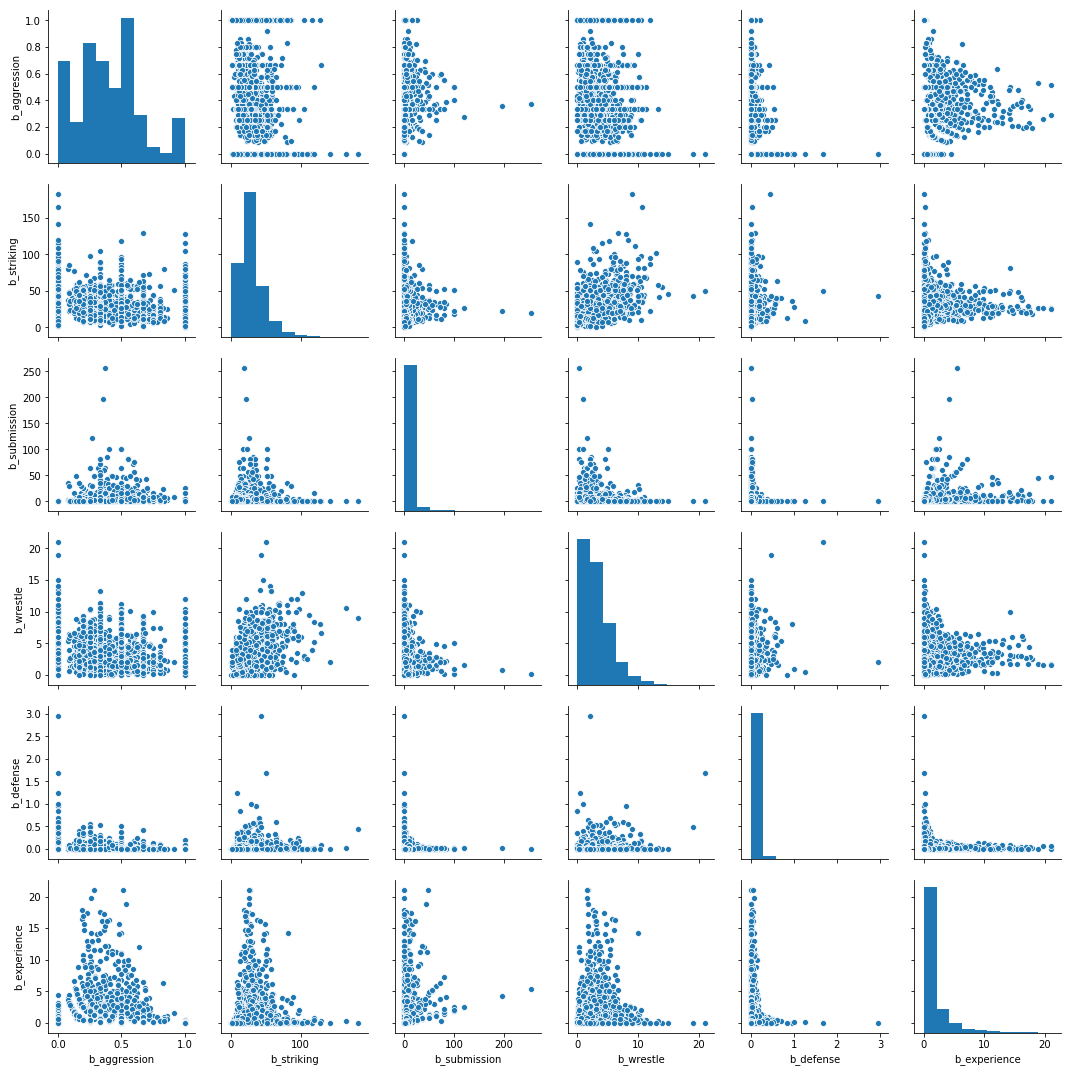

In [20]:
# blue corner pairplot - key feature dataset
sns.pairplot(df_keys[['b_aggression',
                      'b_striking',
                      'b_submission',
                      'b_wrestle',
                      'b_defense',
                      'b_experience'
                      ]])

plt.show()

------------------

### K Means
1. Elbow method plot
2. Silhouette scores and scatterplots
3. SelectKbest
4. SelectPercentile

In [21]:
# define cluster set minus binary target variable
features = df_keys.drop('win_red', axis=1)

In [22]:
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# define cluster set
x = features

# fit and transform
#ss = StandardScaler()
mms = MinMaxScaler()
df_transform = mms.fit_transform(x)

In [23]:
# define k means function and fit data
ss_dist = []
K = range(1,12)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_transform)
    ss_dist.append(km.inertia_) 

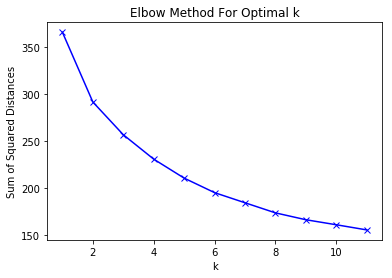

In [24]:
# plot elbow method to determine optimal k clusters
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Observations
- There does not appear to be any distinct "elbow" in the above graph
- Let's try calculating and plotting different k clusters and silhouette score coefficients to see if that sheds any more light on the optimal number of clusters

------------------

### Silhouette Scores

Average silhouette score:
0.16132423973867502


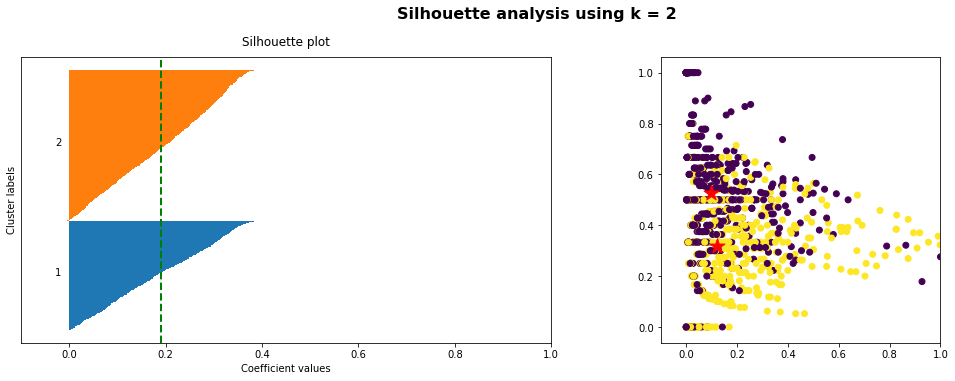

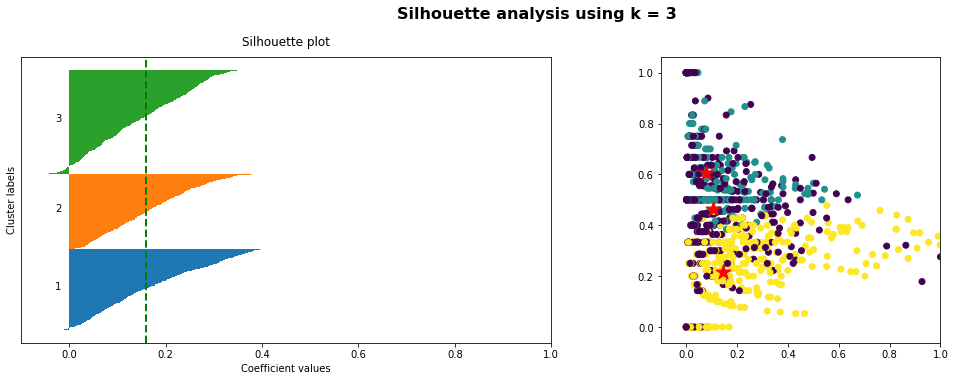

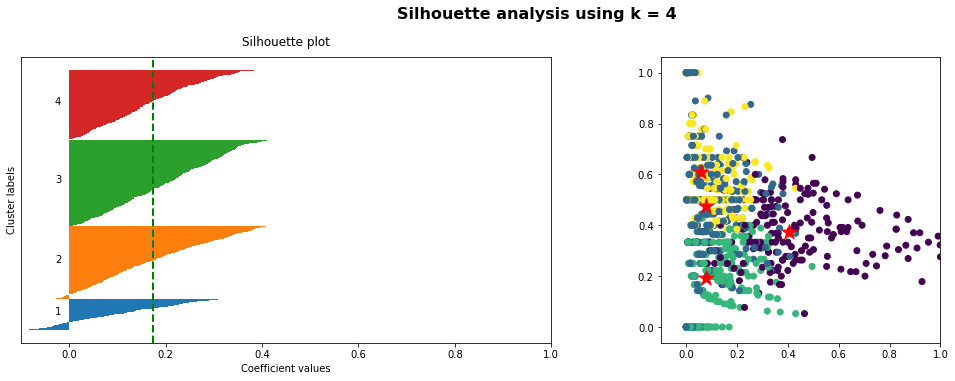

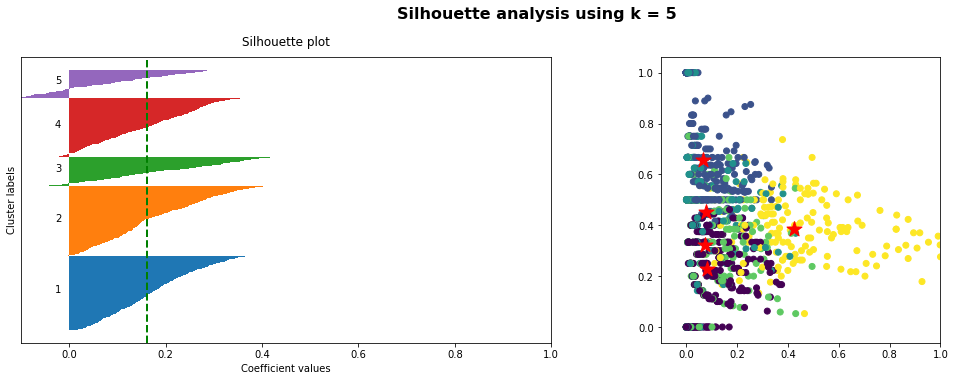

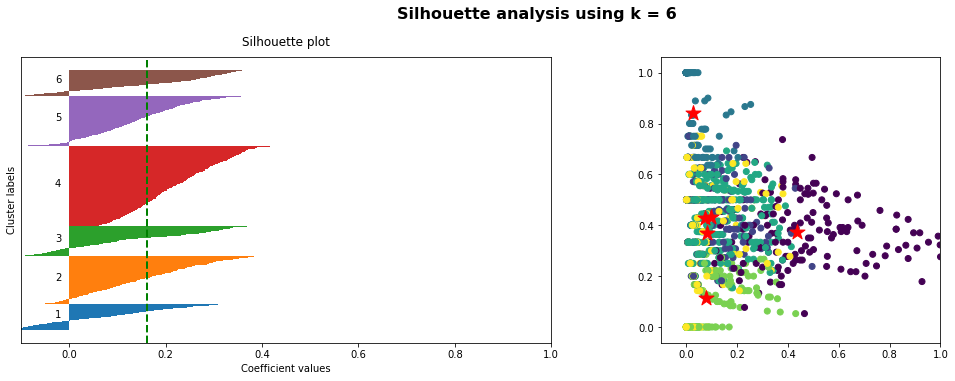

In [25]:
# https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

# plot k clusters 2-6 and silhouette score coefficients for each
for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    
    # kmeans model
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(df_transform)
    centroids = km.cluster_centers_

    # define silhouette samples
    silhouette_vals = silhouette_samples(df_transform, labels)

    # silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # calculate avg silhouette score and plot
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot', y=1.02);
    
    # k clusters scatterplot
    ax2.scatter(df_transform[:, 0], df_transform[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-0.1, 1])
    ax2.set_xlim([-0.1, 1])
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('')
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05)
 
print('Average silhouette score:')
print(avg_score)

#### Observations
- Out of 2-6 k clusters, none of them had a coefficient score above 0.2
- Average silhouette coefficient score over all k clusters is 0.161
- Eyeballing the silhouette plots, 2 k clusters had the highest coefficient score by a neglible amount
- There seems to be no meaningful clusters identified by Kmeans

In [26]:
# WORTH KEEPING?

# selectkbest
# define cluster sets
x = features
y = df_clean.win_red

# fit transform data
x_kbest = SelectKBest(chi2, k=2).fit_transform(x, y)
x_kbest

array([[ 2.7       ,  0.        ],
       [ 1.75      , 10.88888887],
       [ 4.95      ,  6.        ],
       ...,
       [ 0.09      ,  9.00000002],
       [ 0.16      ,  4.        ],
       [ 0.04      ,  4.        ]])

In [27]:
# WORTH KEEPING?

# selectpercentile
# define cluster set
x = features
y = df_clean.win_red

# fit transform data
x_percentile = SelectPercentile(chi2, percentile=10).fit_transform(x, y)
x_percentile

array([[ 2.7       ,  0.        ],
       [ 1.75      , 10.88888887],
       [ 4.95      ,  6.        ],
       ...,
       [ 0.09      ,  9.00000002],
       [ 0.16      ,  4.        ],
       [ 0.04      ,  4.        ]])

------------------

### Principal Component Analysis
1. Transform and create table
2. Scree plot of explained variance
3. 2D scatterplots
4. 3D scatterplots

In [28]:
# principal component analysis
# normalize data
x = features
features_norm = (x-x.min())/(x.max()-x.min())

# define n components and fit transform
pca = PCA(n_components=3, random_state=123)
pca.fit_transform(features_norm)
pca_results = pca.fit_transform(features_norm)

# print pca table ranking features with each component
pd.DataFrame(pca.components_,columns=features_norm.columns,index = ['PC1','PC2', 'PC3'])

,r_experience,r_aggression,r_striking,r_submission,r_wrestle,r_defense,b_experience,b_aggression,b_striking,b_submission,b_wrestle,b_defense
PC1,-0.028446,0.496929,-0.028010,0.017472,-0.028791,-0.027210,-0.033250,0.858902,-0.077029,0.017045,-0.061044,-0.028705
PC2,-0.100837,0.830253,-0.189064,0.012829,-0.134533,-0.037106,0.010159,-0.482493,0.094643,0.001025,0.054355,0.017615
PC3,0.810234,0.069371,-0.033612,0.065361,-0.087794,-0.049397,0.559817,-0.007245,-0.020411,0.065268,-0.066374,-0.025090


#### Observations
- For PC1, the highest ranking variable is blue aggression (0.86)
- For PC2, the highest ranking variable is red aggression (0.83)
- For PC3, the highest ranking variable is red experience (0.81)
- This information will help us conceptualize the contents of clustering, provide context

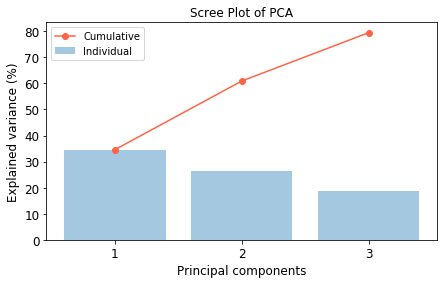

,Component,Indiv,cum_sum
0,1,0.345918,0.345918
1,2,0.263246,0.609164
2,3,0.185354,0.794518


In [29]:
# pca scree plot
x = features
features_norm = (x-x.min())/(x.max()-x.min())
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(x)

fig, ax = plt.subplots(figsize=(7, 4))

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

plt.title('Scree Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)
plt.legend()

plt.show()

# define and print scree table
df_scree = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca.explained_variance_ratio_})
df_scree['cum_sum'] = df_scree['Indiv'].cumsum()
df_scree

#### Observations
- PC1 accounts for 34.5% of the variance
- PC2 accounts for 26.3% of the variance
- PC3 accounts for 18.5% of the variance
- All three prinicpal components combined account for 79.5% of the variance in the data

In [32]:
# define pca components and fit data
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(x)

# define k clusters and fit data
kmeans = KMeans(n_clusters=2)
kmeans = km.fit(pca_results)

# pca results table with k means cluster labels
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2', 'PC3']
df_pca['label'] = kmeans.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,-19.535001,11.236947,-6.092860,0
1,7.250702,33.676099,3.460852,2
2,-6.506626,0.914802,24.865852,4
3,-3.507311,23.945663,1.222555,2
4,24.934348,-10.040650,-3.339058,1


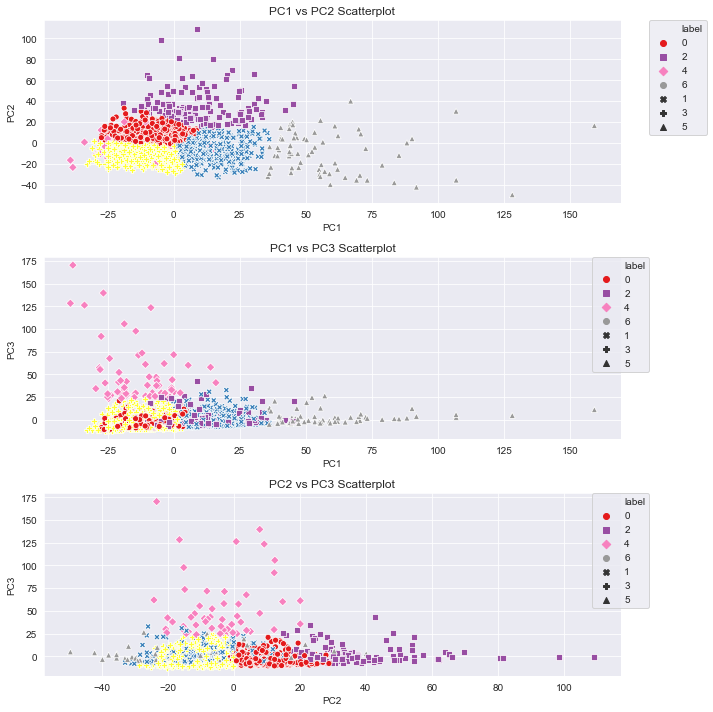

In [33]:
# 2D pca scatterplots - different arrangements
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

# pca1 vs pca2
plt.subplot(3,1,1)
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.title('PC1 vs PC2 Scatterplot')

# pca1 vs pca3
plt.subplot(3,1,2)
sns.scatterplot(data=df_pca, x='PC1', y='PC3', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.title('PC1 vs PC3 Scatterplot')

# pca2 vs pca3
plt.subplot(3,1,3)
sns.scatterplot(data=df_pca, x='PC2', y='PC3', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.title('PC2 vs PC3 Scatterplot')

plt.tight_layout()
plt.show()

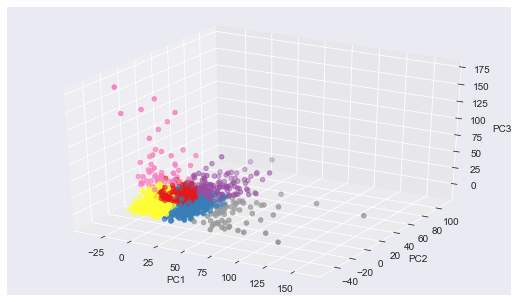

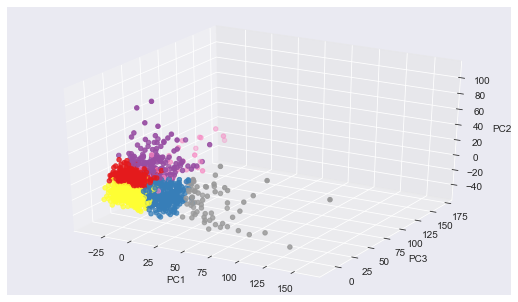

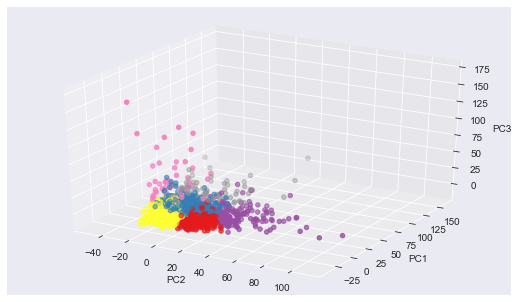

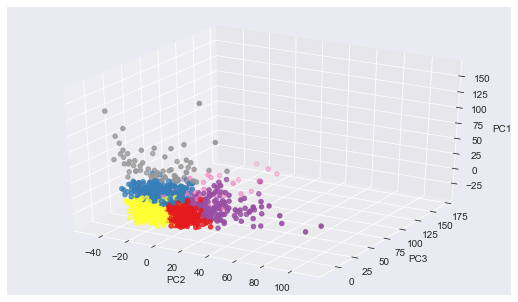

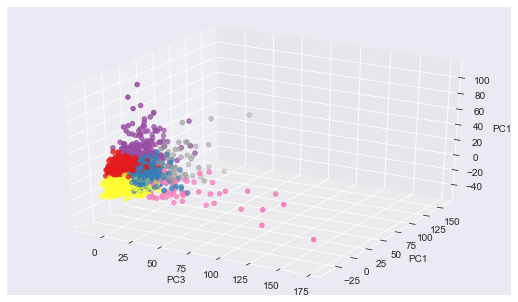

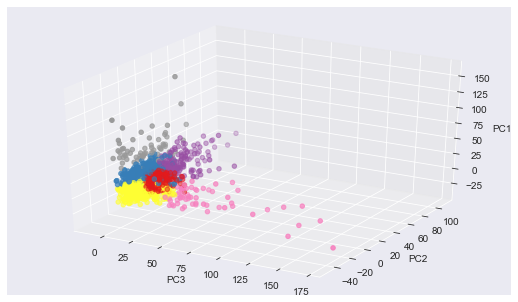

In [34]:
# 3D pca scatterplots - different arrangements
fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC1, df_pca.PC2, df_pca.PC3, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC1, df_pca.PC3, df_pca.PC2, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
ax.set_zlabel('PC2')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC2, df_pca.PC1, df_pca.PC3, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC2')
ax.set_ylabel('PC1')
ax.set_zlabel('PC3')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC2, df_pca.PC3, df_pca.PC1, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC1')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC3, df_pca.PC1, df_pca.PC2, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC3')
ax.set_ylabel('PC1')
ax.set_zlabel('PC1')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_pca.PC3, df_pca.PC2, df_pca.PC1, c=df_pca['label'], cmap='Set1')
ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')
plt.show()

------------------

### T-SNE 
1. Transform and create table
2. 2D scatterplots
3. 3D scatterplots

In [35]:
# T-SNE

# define x
x = features

# define tsne parameters and fit transform
tsne = TSNE(n_components=3, perplexity=50, n_iter=250, random_state=123, learning_rate=190)
tsne_results = tsne.fit_transform(x)

# create and print tsne results table
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['T1', 'T2', 'T3']
df_tsne['label'] = kmeans.labels_
df_tsne.head()

,T1,T2,T3,label
0,0.038838,0.628176,0.008856,0
1,0.382764,0.238859,0.794796,2
2,-0.063472,0.161474,-0.082433,4
3,0.305269,0.378661,0.612243,2
4,0.143120,-0.782767,0.396950,1


<Figure size 720x720 with 0 Axes>

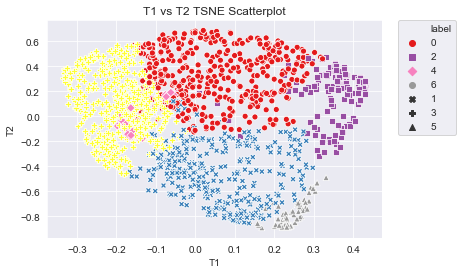

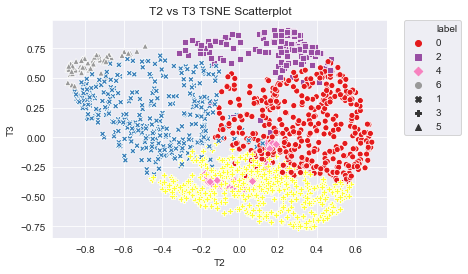

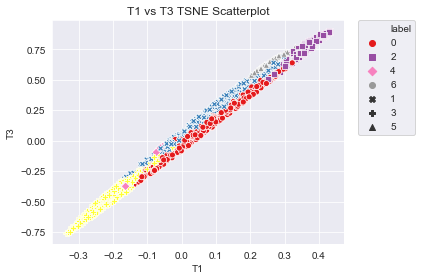

In [36]:
# 2D tsne scatterplots - different arrangements
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

# t1 vs t2
plt.subplots()
sns.scatterplot(data=df_tsne, x='T1', y='T2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('T1 vs T2 TSNE Scatterplot')

# t2 vs t3
plt.subplots()
sns.scatterplot(data=df_tsne, x='T2', y='T3', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('T2 vs T3 TSNE Scatterplot')

# t1 vs t3
plt.subplots()
sns.scatterplot(data=df_tsne, x='T1', y='T3', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('T1 vs T3 TSNE Scatterplot')

plt.tight_layout()
plt.show()

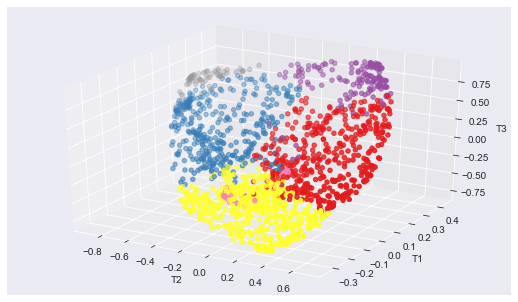

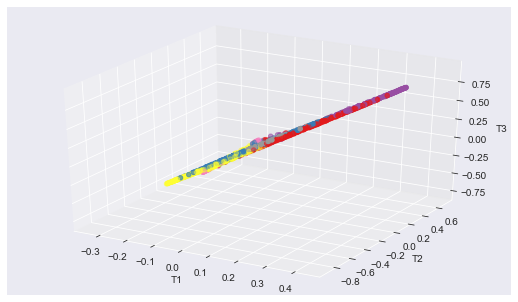

In [37]:
# 3D tsne scatterplots - different arrangements
fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_tsne['T2'], df_tsne['T1'], df_tsne['T3'], c=df_tsne['label'], cmap='Set1')
ax.set_xlabel('T2')
ax.set_ylabel('T1')
ax.set_zlabel('T3')

fig = plt.figure(figsize=(7,4))
ax = Axes3D(fig)
ax.scatter(df_tsne['T1'], df_tsne['T2'], df_tsne['T3'], c=df_tsne['label'], cmap='Set1')
ax.set_xlabel('T1')
ax.set_ylabel('T2')
ax.set_zlabel('T3')

plt.tight_layout
plt.show()

------------------

### Mean Shift
1. Estimated number of clusters

In [38]:
# mean shift

# define cluster sets
x = features
y = df_clean.win_red

# train/test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42)

# define bandwidth
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# fit data
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# extract cluster assignment for each data point
labels = ms.labels_

# define coordinates of cluster centers
cluster_centers = ms.cluster_centers_

# count our clusters
n_clusters_ = len(np.unique(labels))

# print number of clusters
print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 9


#### Observations
- Estimated number of clusters is 9
- This seems like a higher number of clusters than it should be
- There are 12 variables in the data, and reduced to 9 isn't much help in describing anything unique about the data

------------------

### Summary and Conclusion  
- __Kmeans__  
    > - Elbow plot method k cluster determination: 2-3    
    > - Silhouette score coefficient k cluster determination: 2  
    > - Conclusion: no meaningful clusters identified  
    
- __Principal Component Analysis__  
    > - PCA1 highest explained variance: blue aggression (0.86)    
    > - PCA2 highest explained variance: red aggression (0.83)    
    > - PCA3 highest explained variance: red experience (0.81)  
    
- __T-sne__  
    > - No conclusive clusters identified using this method
    > - Data appears close to the shape of a 2D disc, similar to a galaxy of stars or a dinner plate  
    
- __Mean Shift__  
    > - Clusters identified: 9  
    > - This provides little context to the data, as the key feature set contains 12 variables, reducing it to 9 isn't very helpful  
    
-------------------------------  

After loading the dataset, I first cleaned the data and created new interaction variables based on my experience and knowledge in mixed martial arts. Some preliminary exploratory data analysis was performed, followed by unsupervised learning and dimensionality reduction techniques to see if we could identify meaningful clusters or groupings of variables.  

Kmeans was explored first. An elbow method was plotted to help identify the ideal number of k clusters. The resulting plot had more of a uniform curve than a distinct "elbow" joint, providing little insight into the ideal number of k clusters. To further investigate, silhouette coefficient scores were calculated for 2-6 k clusters, followed by plotting these scores plus k means scatterplots for each.  

The average silhouette coefficient score was 0.16, and the highest (2 clusters) did not breach 0.2. From this method it appears there are no identifiable linear patterns or clusters. This is inline with my previous project using supervised learning on this same dataset. One of the major findings in that project was that none of the variables by themselves were directly correlated with the target variables, and little correlation between each other, implying there could be a dimension of non-linearity to the dataset.  

Principal component analysis was next. Reducing the dimensions of the dataset to 3 resulted in an explained variance ratio of 79.5%, which is adequate. The top variables explaining the variance in each component were red aggression score, blue aggression score, and red experience score. This makes sense in the reality of the mixed martial arts world.  

If you will recall, the aggression score calculates how likely a fighter is to finish a fight before it goes to the judges' decision. A high aggression score implies one of two things, either a dominant fighter in one discipline (striking, submission, etc.) or a very well-rounded, skilled, and experienced fighter. The aggression score could be thought of as one unified score for a fighter's overall game.  

The final variable responsible for much of the variance was the red corner experience score. This also makes sense in the real world of mixed martial arts. The red corner is typically reserved for the favored, more experience fighter. The blue corner is often seen as more of the underdog or the newbie. These findings imply that the experience of the red corner does play a significant role in explaining variance in the data.  

The results of T-sne were similar to principal component analysis. It can account for some explained variance but lacks insight when it comes to meaningful patterns or clusters in the data. The data seems to have a shape similar to a galaxy of stars, or a dinner plate, round and spread out, but mostly flat.  

The mean shift model concluded the ideal number of clusters to be 9. Again, this provides little insight into patterns in the data. The dataframe run through the model contained 12 variables, and identifying 9 clusters in 12 variables is essentially meaningless.  

Overall, the results of this project were lackluster to say the least. None of the attempted methods were able to identify linear patterns or clusters in the data. However, dimensionality reduction using principal component analysis resulted in some meaningful findings; you can explain much of the variance in the data using only three variables, namely, red and blue corner agression scores, and red corner experience score. This matches in a sense to the kmeans elbow method recommendation of 2-3 clusters. 

------------------

### Acknowledgments  
- Shubhabrata Roy 
- Rajeev Warrier and his Kaggle dataset (https://www.kaggle.com/rajeevw/ufcdata) 
- Helpful kmeans and silhouette scores article: (https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)  
- Helpful kmeans elbow method plot article: (https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)  
- Thank you!